# Title

### Objective
A recruiting team has been tasked to hire new members for their company's Data Science department from a pool of candidates currently enrolled in a skills development program. The recruiting team would like a model to be built that will highlight the enrollees who are most likely to be interested in a career change and therefore should be targeted for recruitment. The recruitment process consumes a lot of time and resources so the model must be accurate to at least 80% and focus on the precision of it's classification. The recruiting team has provided a list of enrollees that includes various pieces of information about them and whether they would be considered a target or not along with a preliminary list of enrollees that need to be classified. 

### Introduction
This project will walk through the process of building and testing various machine learning models to accomplished the objective stated above. It begins with null value treatment followed by exploratory data analysis and feature engineering. We then build and test two linear models, logistic and support vector, as well as K-nearest Neighbors, Decision Tree, Random Forrest, and finally a bagged model. Each model goes through hyperparameter optimization and some cross validation. These models are then compared based on their accuracy, precision, recall, and run time to determine the best fit for our objective. 

---

### Project Set-up and Data Inspection

#### Packages

A relatively standard suite of packages is used throughout the project including pandas, numpy, seaborn, and matplotlib. Of note would be the joblib package which was used to save the results of some cells with long processing times. Having these results saved in the project's directory severely cuts the time it takes to load the project notebook and refresh it when it is needed. [Scikit Learn](https://scikit-learn.org/stable/about.html#citing-scikit-learn) is the main author used for the machine learning models and evaluation metrics throughout this project.

In [1]:
# Basic Packages
import pandas as pd
import numpy as np
import seaborn as sns
import time
import joblib
import os.path
import matplotlib.pyplot as plt

# Feature Analysis
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

#### Project Style

To keep the project's color scheme and style as coherent as possible we used Seaborn's style and palette settings. The 'darkgrid' style was used to ensure all our graphs stood out from a basic white background. The 'winter' palette (originally from matplotlib) was chosen because the two main colors are distinct yet don't clash with each other while maintaining clarity.

In [2]:
# Set style and color palette for figures
sns.set_style(style = 'darkgrid')
sns.set_palette(palette = 'winter')

---
### Exploratory Data Analysis

#### Data Upload and Inspection

The original datasets were obtained from [Kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)

Two .csv file were provided for this project, one to train the models with that included whether the enrollees were targets or not and the other that included enrollees that needed to be classified. The train dataset was constructed of 14 columns describing 19158 enrollees (rows) while the prediction dataset had 13 columns and 2129 enrollees (rows). 

At first glance it was evident that there are some missing values that will need to be treated as well as a mix of categorical and numeric columns. Before analyzing each columns to decide it's relevance and whether it required any processing or changes the null values needed to be treated to get a full picture of each columns distribution and make up.

In [3]:
# Load train dataset
hrTrain = pd.read_csv('aug_train.csv')
hrTrain

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [4]:
# Load prediction dataset
hrPred = pd.read_csv('aug_test.csv')
hrPred

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [5]:
# Print dataset shapes
print('Train Dataset Shape: ', hrTrain.shape)
print('Test Dataset Shape: ', hrPred.shape)

Train Dataset Shape:  (19158, 14)
Test Dataset Shape:  (2129, 13)


---

#### Null Value Treatment

For this section of the project we analyzed each column for null values and based on that analysis made a decision on whether to fill them or drop the column completely. The training data set had more information to look at so we focused on that for the analysis and then made the same changes to the prediction dataset. 

A heatmap was made to highlight which columns were going to need the most attention and had the highest chance of being dropped. We also built a table to show what percentage of values in each column were null. The columns with the most null values were: `company_type` (32.05%), `company_size` (30.99%), and `gender` (23.53%). It is likely that we drop any column with more than 30% null values but further inspection is needed before making that decision.

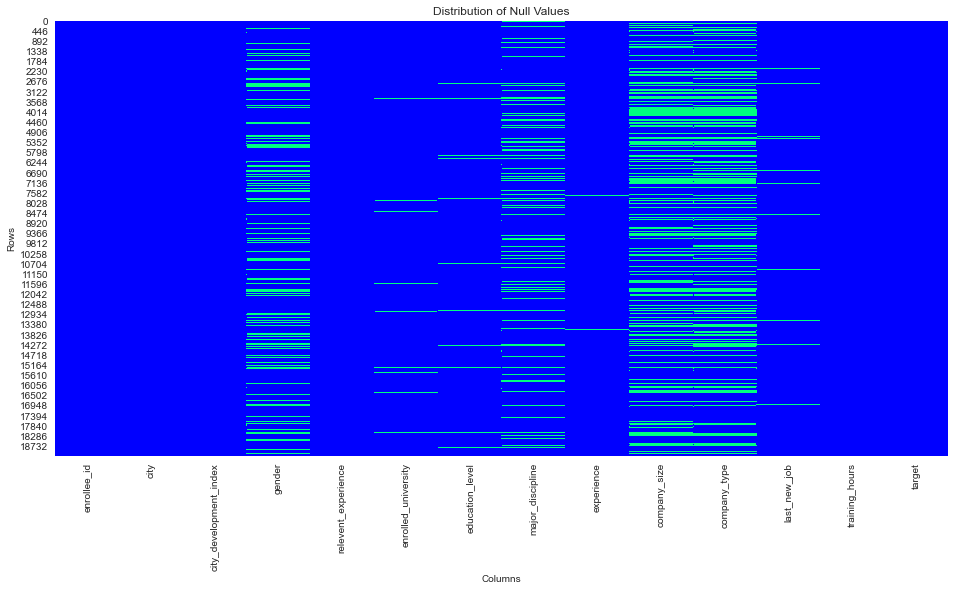

In [6]:
# Plot a heatmap displaying the distribution of null values through the train dataset columns
plt.figure(figsize= (16,8))
ax = plt.axes()
sns.heatmap(hrTrain.isnull(), cbar = False, cmap = 'winter', ax = ax)
ax.set_title('Distribution of Null Values')
ax.set_xlabel('Columns')
ax.set_ylabel('Rows')
plt.show()

In [7]:
# Create a temp dataframe for null vlaue totals
nullTotalDF = pd.DataFrame(hrTrain.isnull().sum()).reset_index()
nullTotalDF.columns = ['Category', 'Total Null']
# Create a temp dataframe for null value percentages
nullPercentDF = pd.DataFrame(round(hrTrain.isnull().sum()/hrTrain.shape[0]*100,2)).reset_index()
nullPercentDF.columns = ['Category', 'Percent Null (%)']
# Merge temporary null value datasets and sort by null percentage
nullDF = pd.merge(nullTotalDF, nullPercentDF, on = 'Category')
nullDF.sort_values('Percent Null (%)', ascending = False)

,Category,Total Null,Percent Null (%)
10,company_type,6140,32.05
9,company_size,5938,30.99
3,gender,4508,23.53
7,major_discipline,2813,14.68
6,education_level,460,2.40
11,last_new_job,423,2.21
5,enrolled_university,386,2.01
8,experience,65,0.34
0,enrollee_id,0,0.00
1,city,0,0.00


#### Categorical Columns
The main goal of our null value treatment is to remove all the null values throughout the dataset without deleting any rows. Some columns may be removed completely but removing a row would be potentially removing a recruitment candidate. That would be counter productive to the objective of this project. In many cases we will not be able to make assumptions on what the null values should be classified as so they will be binned and labeled as 'Other' in many cases.

##### Gender:
The second largest category in the gender columns is null or in other words 'no answer'. We'll make the assumption that many people who do not identify as a male did not want to disclose that gender information and since that was not an option they left that section blank resulting in a null value. For the purpose of our model we'll change the entries in this columns from 'Male' to 'Male ID' for those who identified as Male and to 'Non-Male ID' for all other entries for those who did not choose to identify as male. This will result in a binary classification for the gender column without any null values.

In [8]:
# Display gender column value counts with nulls for the train dataset
hrTrain['gender'].value_counts(dropna = False)

Male      13221
NaN        4508
Female     1238
Other       191
Name: gender, dtype: int64

In [9]:
# Relabelling the gender entries to the desired labels
hrTrain['gender'].replace({'Male':'Male ID', 'Female':'Non-Male ID', 'Other':'Non-Male ID'}, inplace = True)
# Filling the null values for the gender column
hrTrain['gender'].fillna('Non-Male ID', inplace = True)
hrTrain['gender'].value_counts(dropna = False)

Male ID        13221
Non-Male ID     5937
Name: gender, dtype: int64

##### Enrolled University:
There are a relatively small amount of null values for whether or not the enrollee is currently enrolled in a university. We'll categorize these  null values as Other.

In [10]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['enrolled_university'].value_counts(dropna = False)

no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: enrolled_university, dtype: int64

In [11]:
# Relabel no_enrollment to a better format
hrTrain['enrolled_university'].replace({'no_enrollment':'No Enrollment'}, inplace = True)
# Filling the null values to the desired label
hrTrain['enrolled_university'].fillna('Other', inplace = True)
hrTrain['enrolled_university'].value_counts(dropna = False)

No Enrollment       13817
Full time course     3757
Part time course     1198
Other                 386
Name: enrolled_university, dtype: int64

##### Education Level:
We'll change the null values in the `education level` to 'Other' since we can't assume the education level of those who did not fill out this section.

In [12]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['education_level'].value_counts(dropna = False)

Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [13]:
# Filling the null values to the desired label
hrTrain['education_level'].fillna('Other', inplace = True)
hrTrain['education_level'].value_counts(dropna = False)

Graduate          11598
Masters            4361
High School        2017
Other               460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

##### Major Discipline:
We have more null values than many of the alternative options that were presented to the enrollees. We'll change this category into a binary classification where the education major is either STEM or Non-STEM.

In [14]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['major_discipline'].value_counts(dropna = False)

STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [15]:
# Relabelling the gender entries to the desired labels
hrTrain['major_discipline'].replace(dict.fromkeys(['Humanities', 'Other', 'Business Degree', 'No Major', 'Arts'], 'Non-STEM'), inplace = True)
# Filling the null values to the desired label
hrTrain['major_discipline'].fillna('Non-STEM', inplace = True)
hrTrain['major_discipline'].value_counts(dropna = False)

STEM        14492
Non-STEM     4666
Name: major_discipline, dtype: int64

##### Experience:
There are relatively few null values for years of experience but simply setting these all to 'Other' like we had done with other categories does not make sense with these numeric values. Let's set them to the average of our set. This requires us to do some additional manipulation to find out what that average is since we have some non-numeric values as well as them currently being strings. 

In [16]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['experience'].value_counts(dropna = False)

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
NaN      65
Name: experience, dtype: int64

In [17]:
# Calculationg the average of our years of experience

# Get list of experience values
exp = hrTrain['experience'].dropna().tolist()
# Convert non-numeric entries to numbers in string format
for i in range(0, len(exp)):
    if exp[i] == '<1':
        exp[i] = '0'
    elif exp[i] == '>20':
        exp[i] = '21'
    # Change all list entries from strings to numbers
    exp[i] = int(exp[i])
# Calculate the mean ecperience of all our enrollees
mean = round(sum(exp)/len(exp))
print("The mean years of experience is: ",mean)

The mean years of experience is:  10


In [18]:
# Set the null values to the average of our enrollee experince 
hrTrain['experience'].fillna('10', inplace = True)

The years of experience metric is little flawed as it is both very specific and very broad. This category is useful for picking out enrollees in different stages of their career not the specific number of years they have experience for. To make this categorizations more meaningful we'll bin the years into 5 year groups to see what the distribution looks like based on the stage of their career that each enrollee is in. 

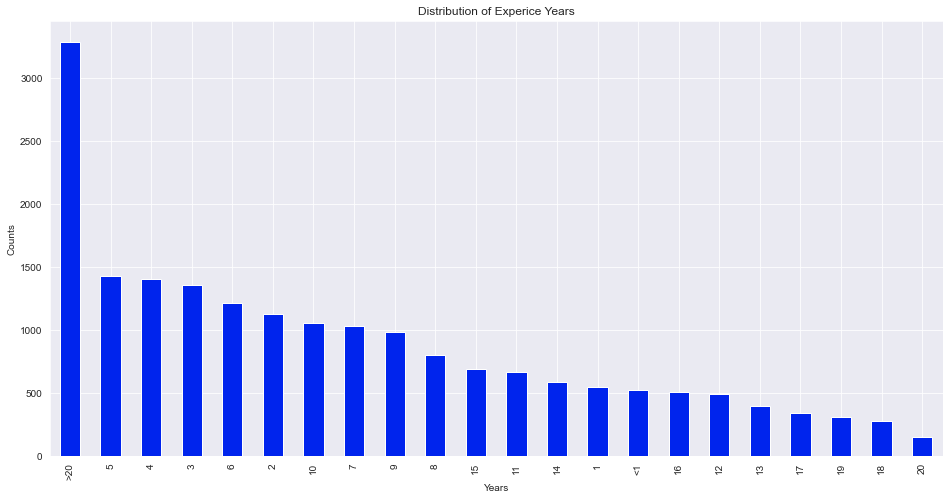

In [19]:
# Plot the distribution of experince years and their counts
plt.figure(figsize= (16,8))
ax = plt.axes()
hrTrain['experience'].value_counts().plot(kind = 'bar', ax = ax)
ax.set_title('Distribution of Experice Years')
ax.set_xlabel('Years')
ax.set_ylabel('Counts')
plt.show()

In [20]:
# Binning ranges of 5 years into new categories
hrTrain['experience'].replace(dict.fromkeys(['<1', '1', '2', '3', '4'], '<5'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['8', '9', '5', '6', '7'], '5-9'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['10','11', '12', '13', '14'], '10-14'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['15', '16', '17', '18', '19', '20'], '15-20'), inplace = True)
hrTrain['experience'].value_counts()

5-9      5456
<5       4955
>20      3286
10-14    3193
15-20    2268
Name: experience, dtype: int64

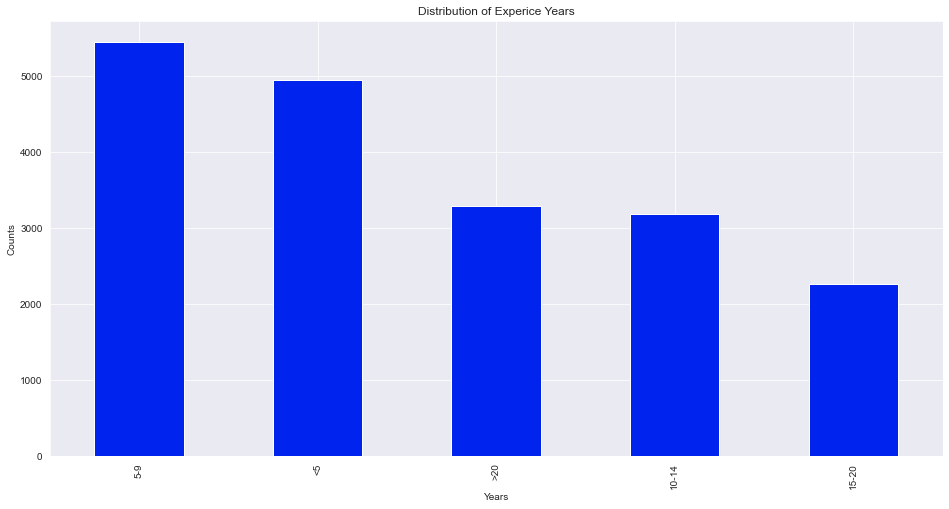

In [21]:
# Plot the distribution of experince stages and their counts
plt.figure(figsize= (16,8))
ax = plt.axes()
hrTrain['experience'].value_counts().plot(kind = 'bar', ax = ax)
ax.set_title('Distribution of Experice Years')
ax.set_xlabel('Years')
ax.set_ylabel('Counts')
plt.show()

These classifications are a lot more useful and mean more to the analysis. This will also drastically reduce the number of features our models have to analyze later on int he project. 

##### Company Size:
There are more null values than any other of the numeric buckets for the `company_size` category. We cannot use an average because it is the number one category and using 'Other' isn't a valid option. We will drop the company_size category altogether.

In [22]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['company_size'].value_counts(dropna = False)

NaN          5938
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [23]:
# Droping the company size column from both datasets
hrTrain.drop(['company_size'], axis = 1, inplace = True)

##### Company Type:
We'll change the null values in the `company type` to 'Other' since we can't assume the type of those who did not fill out this section.

In [24]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['company_type'].value_counts(dropna = False)

Pvt Ltd                9817
NaN                    6140
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

In [25]:
# Lebeled null values as 'Other'
hrTrain.fillna('Other', inplace = True)

##### Categorical Null Value Treatment Summary:  
* Gender: Changed to binary classification of: identified as male or did not identify as male which included the null values
* Enrolled University: Null values set to 'Other'
* Education Level: Null values set to 'Other'
* Major Discipline: Changed to binary classification of: STEM or NON-STEM which included the null values
* Experience: Null values were set to the average of the train dataset. Values were then binned into 5 year groups.
* Company Size: Dropped from the dataset
* Company Type: Null values set to 'Other'

In [26]:
# Post treatment null value counts
hrTrain.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

#### Other Categorical Column Analysis
`Enrollee_id` is a unique identifier and therefore not useful for modeling it can be dropped. `City` doesn't affect our objective and it is very likely we run into a future enrollee that does not work in one of the 123 cites from the original dataset. This means that this metric is not useful and it will cause issues at some point so we will remove it from the dataset. `relevent_experience` does not need any changes at this time. For the `Last_new_job` column we'll combine the 'Other' values into 'Never' since having an 'Other' value for this category does not make sense and all other possible options are available within the range of years given as possible answers.  

In [27]:
# Drop enrollee id column
hrTrain.drop('enrollee_id', axis = 1, inplace = True)
# Drop city column
hrTrain.drop('city', axis = 1, inplace = True)
# Relabel Other to Never for the last_new_job
# hrTrain['last_new_job'].replace(dict.fromkeys(['Other'], 'never'), inplace = True)

--- 
### Univariate Analysis
The next step we took is to write a function to create some simple charts for univariate analysis. This function will take a column name and output two charts. The first compares the number of targets and non-targets for each unique value within a column. This will allow us to pinpoint which values are more present between column values in targeted enrollees. The second chart compares the percentage of targeted enrollees within each individual value. This will help normalize the counts from the first chart which may be misleading due to any potential volume imbalance.   

In [28]:
# Function to produce two charts for univariate analysis
def univar(dataset, column, width = 0.2):
    # Create list variable for the function
    labels = np.unique(dataset[column].tolist())
    targetList = []
    nonTargetList = []
    percents = []
    width = width
    labelLen = np.arange(len(labels))

    # For loop to separate each unique value and the recruitment potential
    for i in labels:
        # Make list of all rows with a unique value and is a target
        colCountTarget = len(dataset.loc[(dataset[column] == i) & (dataset['target'] == 1)])
        targetList.append(colCountTarget)
        # Make list of all rows with a unique value and is not a target
        colCountNotTarget = len(dataset.loc[(dataset[column] == i) & (dataset['target'] == 0)])
        nonTargetList.append(colCountNotTarget)
        # Make a list of percentage target for each unique value
        perCol = round(colCountTarget/(colCountTarget+colCountNotTarget)*100,2)
        percents.append(perCol)
    
    # Subplot set up and features
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    fig.suptitle(f'Univariate Analysis of {str(column).title()}')
    
    # ax1 - Double bar chart for targeted and non-targeted counts for unique values
    ax1.bar(labelLen - width/2, targetList, width, label = 'Target', edgecolor = 'black', color = 'c')
    ax1.bar(labelLen + width/2, nonTargetList, width, label = 'Non-Target', edgecolor = 'black', color = 'b')
    # ax1 - Graph elements
    ax1.set_ylabel('Number of Enrollees')
    ax1.set_xlabel(str(column).title())
    ax1.set_title(f'Total Enrollee Target Comparison by {str(column).title()}')
    ax1.set_xticks(labelLen)
    ax1.set_xticklabels(labels, rotation = 15)
    ax1.legend()
    
    # ax2 - Bar cahrt for percent targeted by each unique value
    ax2.bar(labels, percents, edgecolor = 'black', color = {'c', 'b'})
    # ax2 - Graph elements
    ax2.set_ylabel('Percent Targeted (%)')
    ax2.set_xlabel(str(column).title())
    ax2.set_title(f'Enrollee Percent Targeted Comparison by {str(column).title()}')
    ax2.set_xticklabels(labels, rotation = 15)
    
    plt.show()

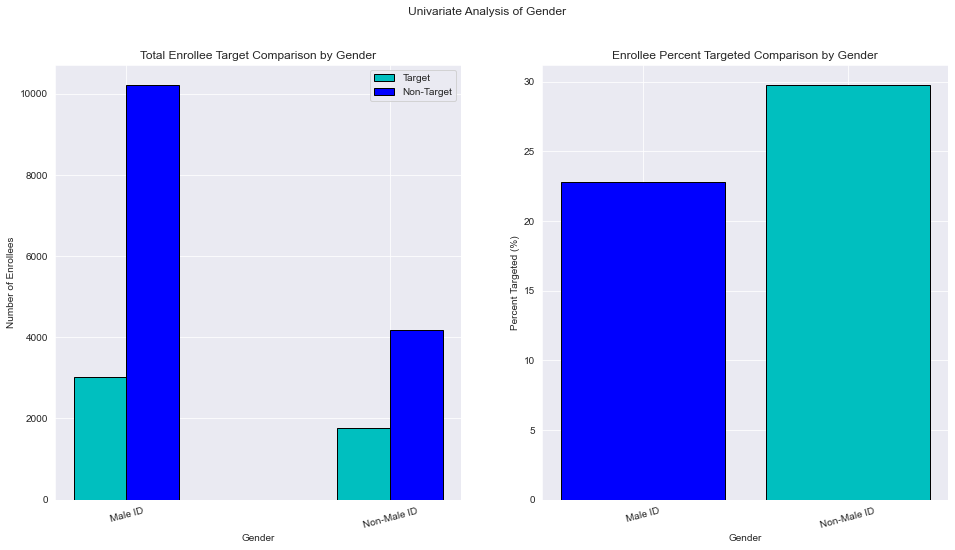

In [29]:
univar(hrTrain,'gender')

We can see that there are more total targets who are male identifying but an enrollee that is non-male identifying is more likely to be a target by roughly 7%.

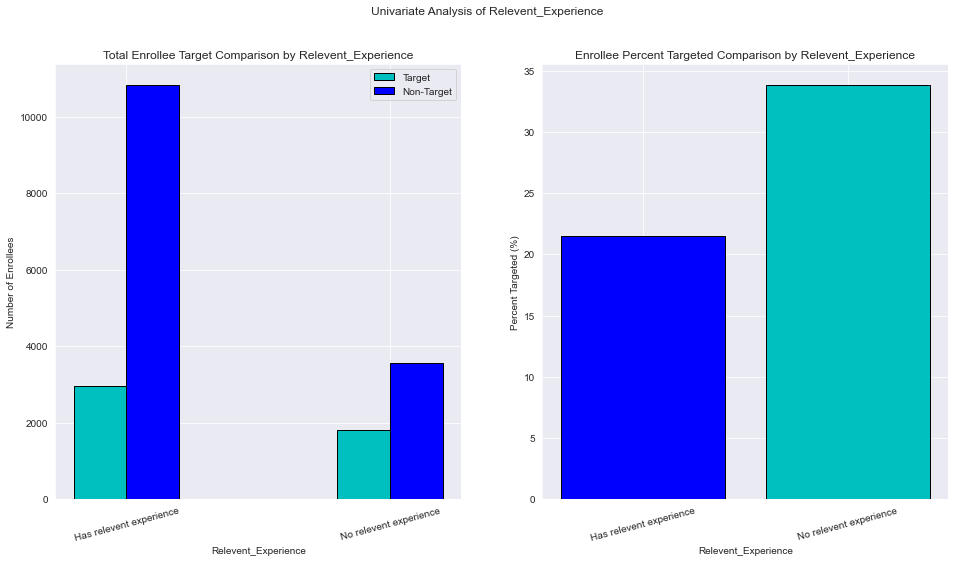

In [30]:
univar(hrTrain,'relevent_experience')

We can see that there are more total targets who have relevant experience but an enrollee that has no relevant experience is more likely to be a target by roughly 12%.

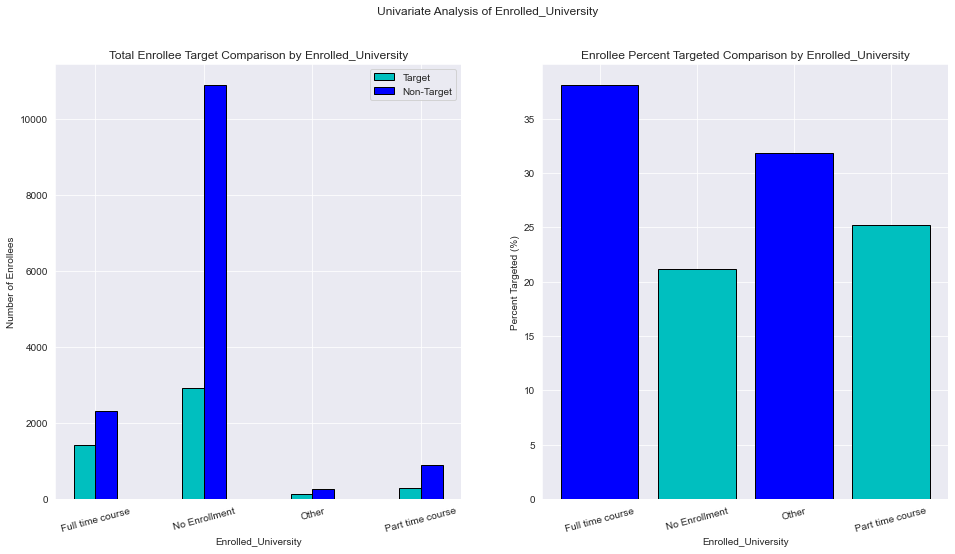

In [31]:
univar(hrTrain,'enrolled_university')

Enrollees with no enrollment in a university are the most common recruitment targets but those enrolled full time are targeted most per capita followed by Other by roughly 6%.

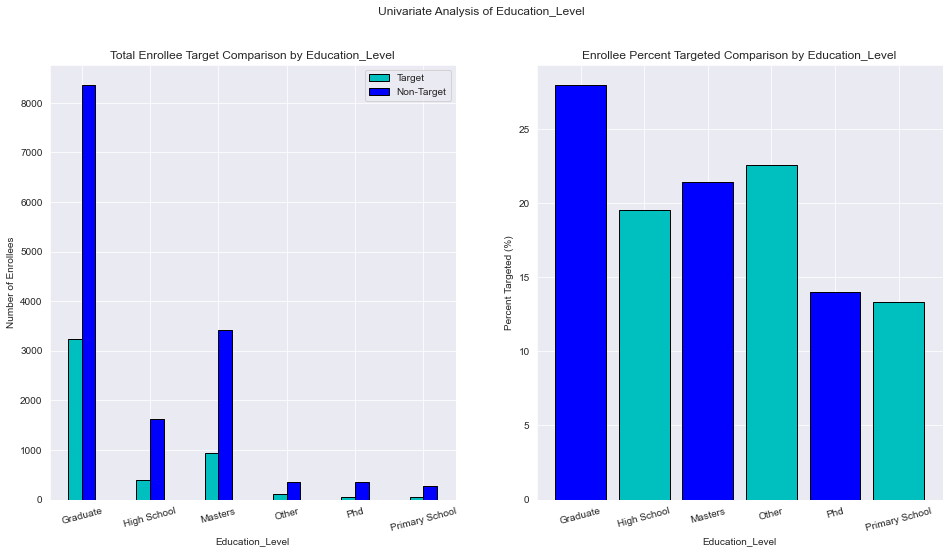

In [32]:
univar(hrTrain,'education_level')

Enrollees with an education level of Graduate are both the most common and most likely target for recruitment.

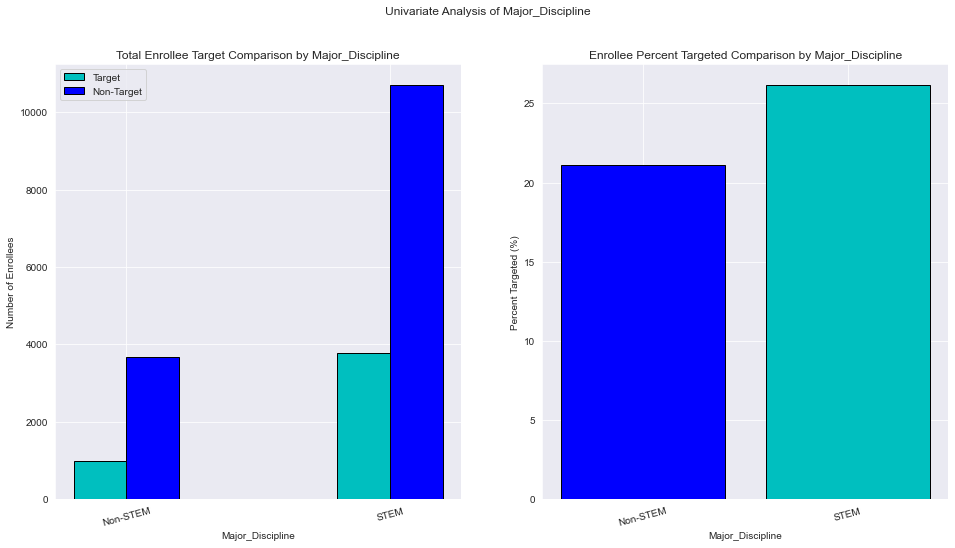

In [33]:
univar(hrTrain,'major_discipline')

Enrollees who majored in a STEM are the most common and most likely recruitment targets. 

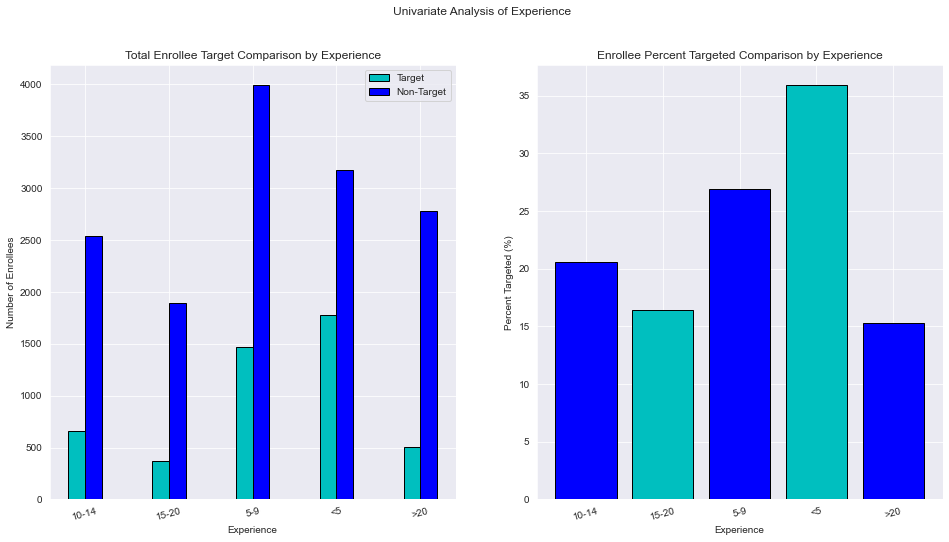

In [34]:
univar(hrTrain,'experience')

Enrollees who have less than 5 years of experience are the most common and most likely recruitment targets.

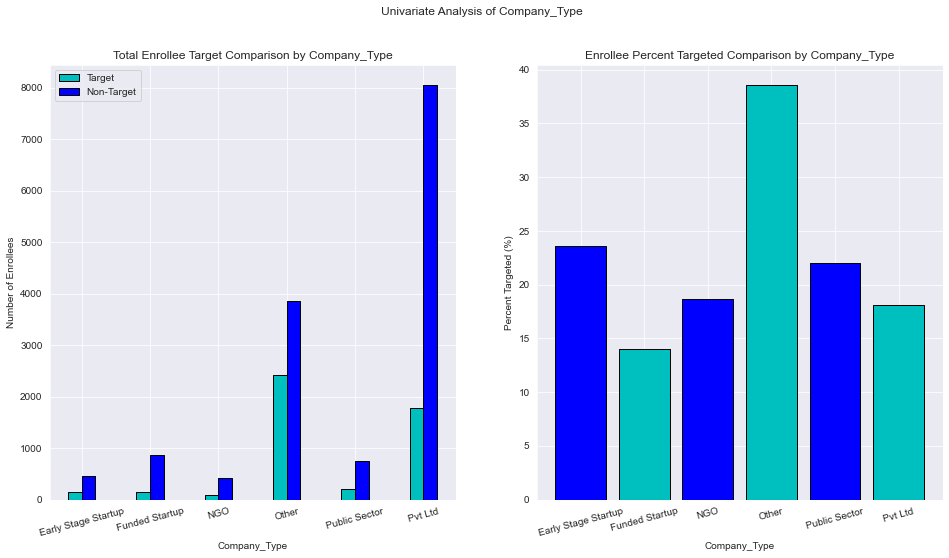

In [35]:
univar(hrTrain,'company_type')

Enrollees who's current employer does not fit into one of the generic options (i.e. Other) are the most common and most likely to be recruitment targets. 

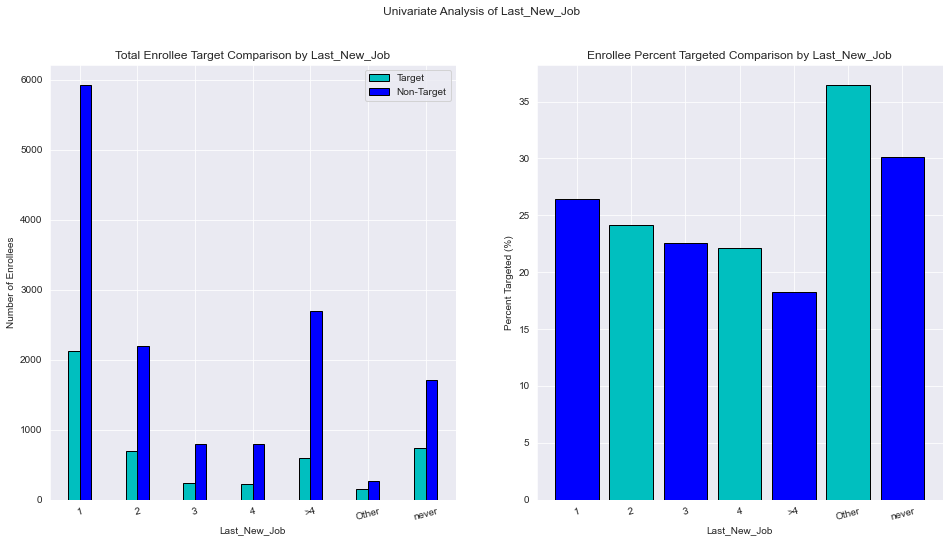

In [36]:
univar(hrTrain,'last_new_job')

Enrollees with 1 year since their last job are the most common recruitment target but those who have never changed jobs are the most likely by roughly 5%.

---
#### Numeric Category Analysis
The distribution and quantiles of the numeric columns were analyzed where their outliers were checked and treated if necessary. 
##### City Development Index:
The majority of enrollees are found in cities with a development index above 0.9. The median of those who are not a recruitment target is much higher, just over 0.9, than those who are targets which sits around 0.7. There is also a much tighter interquartile range for the non-targeted enrollees which indicates the city development index is less variable for those who are not targeted. There are some "outliers" in this metric according to the boxplot below but since the city development index is a qualitative metric we shouldn't be capping them in our analysis. We can also see that the distribution doesn't follow any coherent shape that we typically expect. Based on these factors we decided that `city_development_index` is more suited for a categorical columns binned into a range of qualities: low, medium, high.

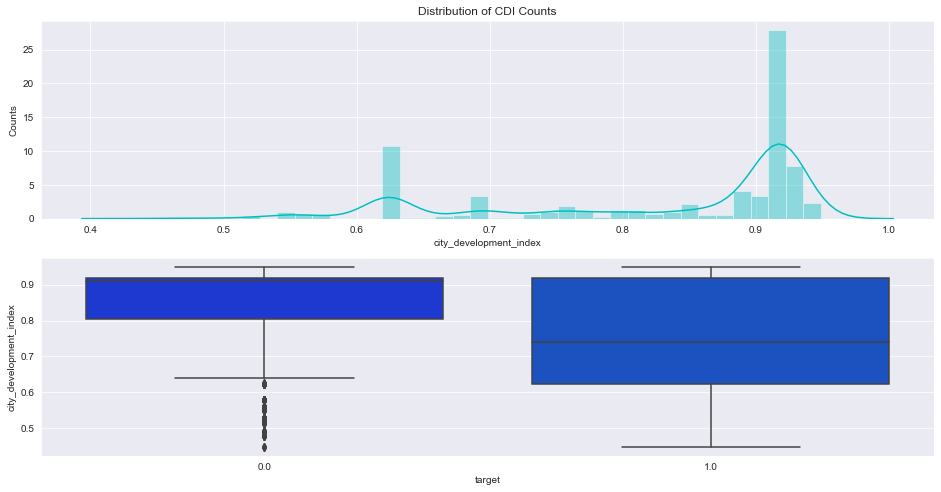

In [37]:
# Distribution and boxplot charts
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ax1 = sns.distplot(hrTrain['city_development_index'], color = 'c')
ax1.set(title = 'Distribution of CDI Counts', ylabel = 'Counts')
plt.subplot(2,1,2)
ax2 = sns.boxplot(y = hrTrain['city_development_index'], x = hrTrain['target'])
plt.show()

In [38]:
# # Change CDI values to a categorical value based on the range they fall into
# cdiList = hrTrain['city_development_index'].tolist()
# for i in range(0, len(cdiList)):
#     if cdiList[i] < 0.700:
#         cdiList[i] = 'Low'
#     elif (cdiList[i] >= 0.700) & (cdiList[i] < 0.910):
#         cdiList[i] = 'Medium'
#     else:
#         cdiList[i] = 'High'
# hrTrain['city_development_index'] = cdiList

In [39]:
# univar(hrTrain,'city_development_index')

Enrollees from Low city development indexes are both the most common and most likely to be targeted by the recruitment team.

##### Training Hours:
We can see that the distribution of training hours is much more typical for numeric metrics although it is quite skewed. We can see a large number of glaring outliers for both the target and non-target groups. We'll cap these outliers at the 95th percentile sot hey do not interfere with out model outputs.

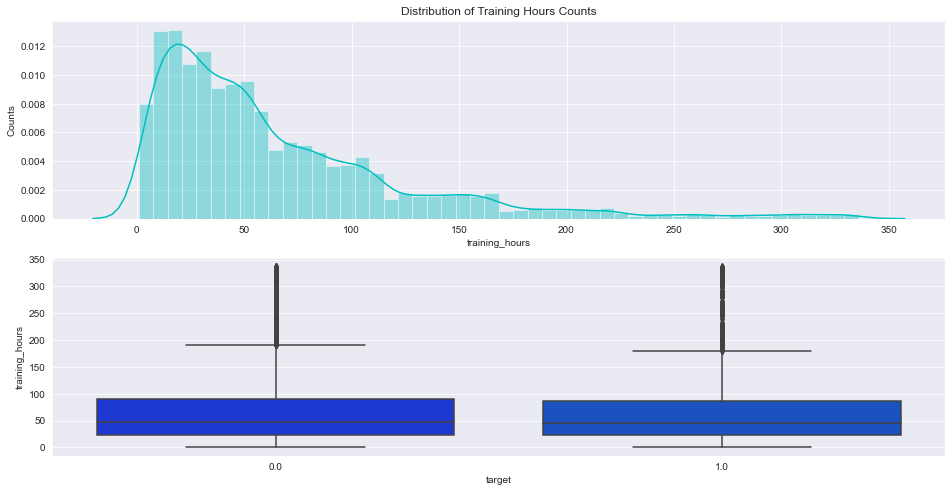

In [40]:
# Distribution and boxplot charts
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ax1 = sns.distplot(hrTrain['training_hours'], color = 'c')
ax1.set(title = 'Distribution of Training Hours Counts', ylabel = 'Counts')
plt.subplot(2,1,2)
sns.boxplot(y = hrTrain['training_hours'], x = hrTrain['target'])
plt.show()

In [41]:
# Change any values above the 95th percentile equal to the 95th percentile
q95 = hrTrain['training_hours'].quantile(0.95)
hrTrain.loc[hrTrain['training_hours'] >= q95, 'training_hours'] = q95

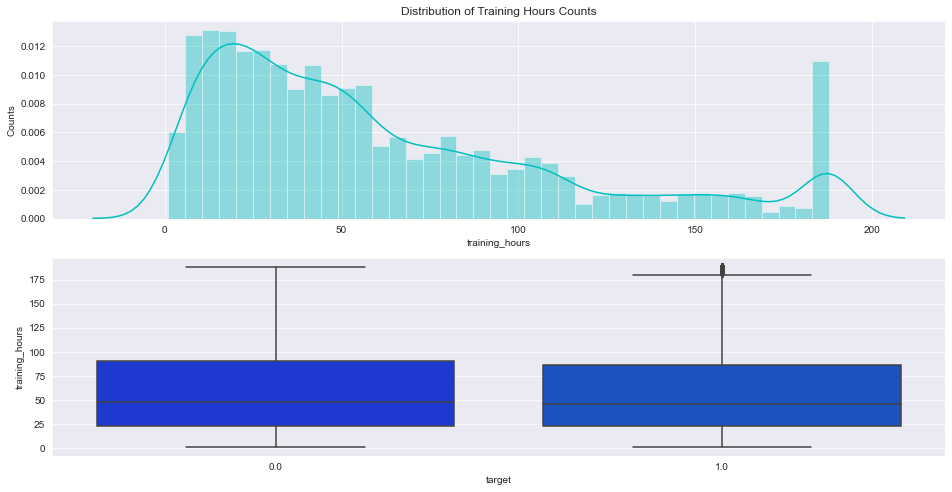

In [42]:
# Distribution and boxplot charts
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ax1 = sns.distplot(hrTrain['training_hours'], color = 'c')
ax1.set(title = 'Distribution of Training Hours Counts', ylabel = 'Counts')
plt.subplot(2,1,2)
sns.boxplot(y = hrTrain['training_hours'], x = hrTrain['target'])
plt.show()

Finally we can take a look at the Target column to see if dataset is balanced or not. With a 3:1 ratio between targeted enrollees and non-targeted means out sataset is unbalanced and we will have to do some some re-sampling to even it out.

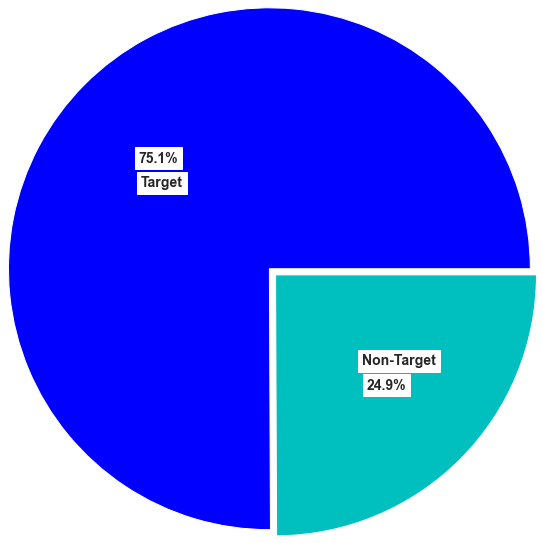

In [43]:
# Plot target distribution
targetCounts = hrTrain['target'].value_counts().to_frame('counts')
plt.figure()
plt.pie(targetCounts.counts, explode = (0, 0.1), labels = ['Non-Target', 'Target'], autopct='%1.1f%%', radius = 3, labeldistance = -0.5, colors = ['b', 'c'], textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
plt.show()

---
#### Dataset Conversion Function
We have done quite a bit of data manipulation and trimming on the train dataset. This needs to be replicated on the predict dataset so it will properly fir into our final model.

In [44]:
def dataPrep(dataset):
    # Relabelling the gender entries to the desired labels
    dataset['gender'].replace({'Male':'Male ID', 'Female':'Non-Male ID', 'Other':'Non-Male ID'}, inplace = True)
    # Filling the null values for the gender column
    dataset['gender'].fillna('Non-Male ID', inplace = True)
    
    # Relabel no_enrollment to a better format
    dataset['enrolled_university'].replace({'no_enrollment':'No Enrollment'}, inplace = True)
    # Filling the null values to the desired label
    dataset['enrolled_university'].fillna('Other', inplace = True)

    # Filling the null values to the desired label
    dataset['education_level'].fillna('Other', inplace = True)
    dataset['education_level'].value_counts(dropna = False)
    
    # Relabelling the gender entries to the desired labels
    dataset['major_discipline'].replace(dict.fromkeys(['Humanities', 'Other', 'Business Degree', 'No Major', 'Arts'], 'Non-STEM'), inplace = True)
    # Filling the null values to the desired label
    dataset['major_discipline'].fillna('Non-STEM', inplace = True)
    
    # Binning ranges of 5 years into new categories
    dataset['experience'].fillna('10', inplace = True)
    dataset['experience'].replace(dict.fromkeys(['<1', '1', '2', '3', '4'], '<5'), inplace = True)
    dataset['experience'].replace(dict.fromkeys(['8', '9', '5', '6', '7'], '5-9'), inplace = True)
    dataset['experience'].replace(dict.fromkeys(['10','11', '12', '13', '14'], '10-14'), inplace = True)
    dataset['experience'].replace(dict.fromkeys(['15', '16', '17', '18', '19', '20'], '15-20'), inplace = True)
    
    # Droping the company size column from both datasets
    dataset.drop(['company_size'], axis = 1, inplace = True)
    
    # Lebeled null values as 'Other'
    dataset.fillna('Other', inplace = True)
    
    # Drop enrollee id column
    dataset.drop('enrollee_id', axis = 1, inplace = True)
    # Drop city column
    dataset.drop('city', axis = 1, inplace = True)
    # Relabel Other to Never for the last_new_job
    # dataset['last_new_job'].replace(dict.fromkeys(['Other'], 'never'), inplace = True)
    
    # Change CDI values to a categorical value based on the range they fall into
#     cdiListNT = dataset['city_development_index'].tolist()
#     for i in range(0, len(cdiListNT)):
#         if cdiListNT[i] < 0.700:
#             cdiListNT[i] = 'Low'
#         elif (cdiListNT[i] >= 0.700) & (cdiListNT[i] < 0.910):
#             cdiListNT[i] = 'Medium'
#         else:
#             cdiListNT[i] = 'High'
#     dataset['city_development_index'] = cdiListNT

    # Change any values above the 95th percentile equal to the 95th percentile
    q95 = dataset['training_hours'].quantile(0.95)
    dataset.loc[dataset['training_hours'] >= q95, 'training_hours'] = q95

In [45]:
dataPrep(hrPred)

### Data Prep

In [46]:
hrTrain

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_type,last_new_job,training_hours,target
0,0.920,Male ID,Has relevent experience,No Enrollment,Graduate,STEM,>20,Other,1,36.0,1.0
1,0.776,Male ID,No relevent experience,No Enrollment,Graduate,STEM,15-20,Pvt Ltd,>4,47.0,0.0
2,0.624,Non-Male ID,No relevent experience,Full time course,Graduate,STEM,5-9,Other,never,83.0,0.0
3,0.789,Non-Male ID,No relevent experience,Other,Graduate,Non-STEM,<5,Pvt Ltd,never,52.0,1.0
4,0.767,Male ID,Has relevent experience,No Enrollment,Masters,STEM,>20,Funded Startup,4,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,Male ID,No relevent experience,No Enrollment,Graduate,Non-STEM,10-14,Other,1,42.0,1.0
19154,0.920,Male ID,Has relevent experience,No Enrollment,Graduate,STEM,10-14,Other,4,52.0,1.0
19155,0.920,Male ID,Has relevent experience,No Enrollment,Graduate,STEM,>20,Pvt Ltd,4,44.0,0.0
19156,0.802,Male ID,Has relevent experience,No Enrollment,High School,Non-STEM,<5,Pvt Ltd,2,97.0,0.0


In [47]:
hrTrain = pd.get_dummies(hrTrain, drop_first = True)
hrPred = pd.get_dummies(hrPred, drop_first = True)
hrTrain

,city_development_index,training_hours,target,gender_Non-Male ID,relevent_experience_No relevent experience,enrolled_university_No Enrollment,enrolled_university_Other,enrolled_university_Part time course,education_level_High School,education_level_Masters,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_Other,last_new_job_never
0,0.920,36.0,1.0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.776,47.0,0.0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.624,83.0,0.0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.789,52.0,1.0,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.767,8.0,0.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,42.0,1.0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19154,0.920,52.0,1.0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
19155,0.920,44.0,0.0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
19156,0.802,97.0,0.0,0,0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0


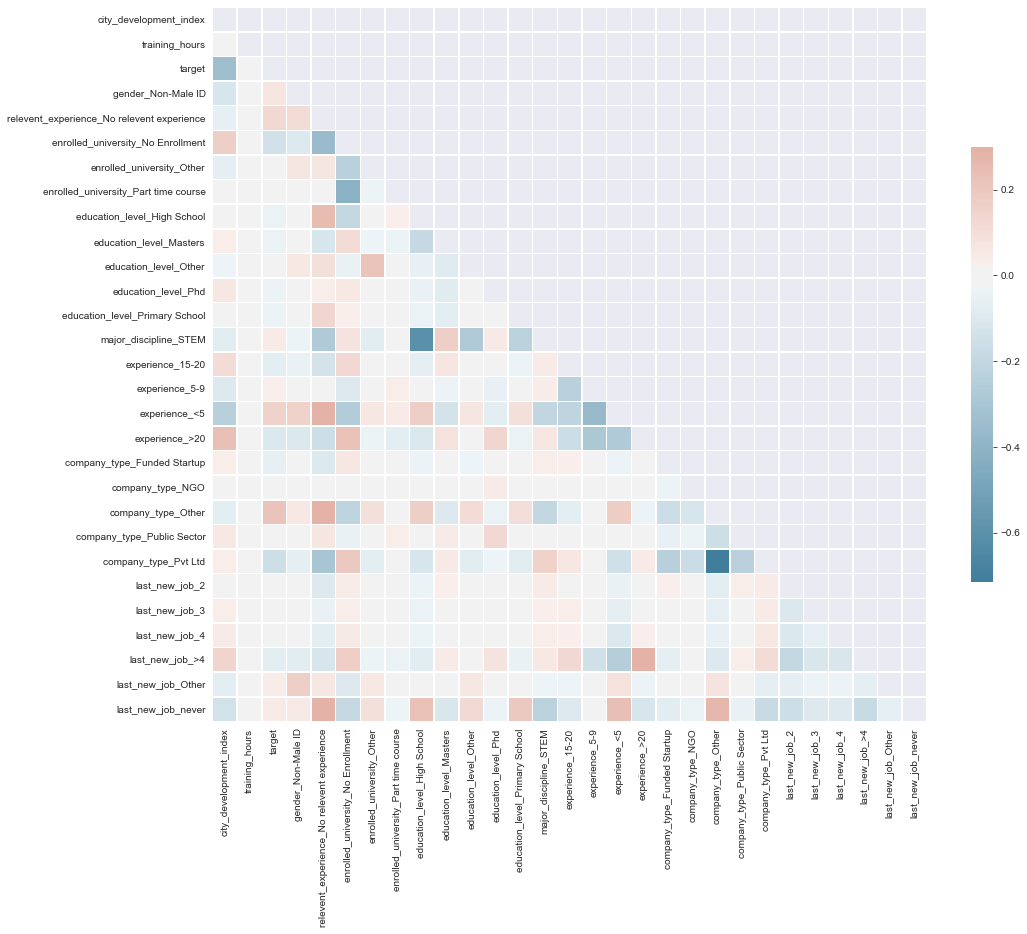

In [48]:
corr = hrTrain.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [49]:
corrTrain = hrTrain.corr()
corrDF = corrTrain.unstack().reset_index()
corrDF.columns = ['VAR1', 'VAR2', 'Correlation']
corrDF = corrDF[corrDF.Correlation != 1.0]
corrDF = corrDF[corrDF.Correlation != -1.0]
corrDF.sort_values(by='Correlation', ascending=False, inplace=True)
corrDF

,VAR1,VAR2,Correlation
816,last_new_job_never,relevent_experience_No relevent experience,0.370292
144,relevent_experience_No relevent experience,last_new_job_never,0.370292
136,relevent_experience_No relevent experience,company_type_Other,0.354971
584,company_type_Other,relevent_experience_No relevent experience,0.354971
468,experience_<5,relevent_experience_No relevent experience,0.352570
...,...,...,...
152,enrolled_university_No Enrollment,enrolled_university_Part time course,-0.415404
385,major_discipline_STEM,education_level_High School,-0.604542
245,education_level_High School,major_discipline_STEM,-0.604542
658,company_type_Pvt Ltd,company_type_Other,-0.714283


In [50]:
X = hrTrain.drop(['target'], axis = 1)
Y = pd.DataFrame(hrTrain['target'])

overSample = SMOTE(random_state = 12)
Xsm, Ysm = overSample.fit_resample(X, Y)

Before resampling there were 14381 NON_TARGETTED enrollees
Before resampling there were 4777 TARGETTED enrollees
After resampling there were 14381 NON_TARGETTED enrollees
After resampling there were 14381 TARGETTED enrollees


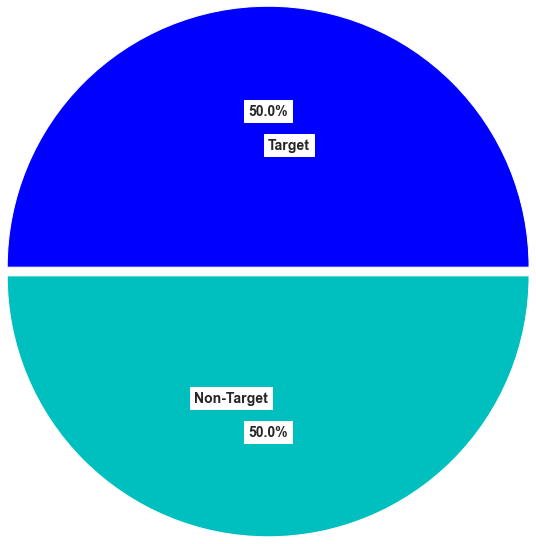

In [51]:
print(f"Before resampling there were {len(Y.loc[(Y['target'] == 0.0)])} NON_TARGETTED enrollees")
print(f"Before resampling there were {len(Y.loc[(Y['target'] == 1.0)])} TARGETTED enrollees")
print(f"After resampling there were {len(Ysm.loc[(Ysm['target'] == 0.0)])} NON_TARGETTED enrollees")
print(f"After resampling there were {len(Ysm.loc[(Ysm['target'] == 1.0)])} TARGETTED enrollees")

targetCountsSM = Ysm['target'].value_counts()
plt.pie(targetCountsSM, explode = (0, 0.1), labels = ['Non-Target', 'Target'], autopct='%1.1f%%', radius = 3, labeldistance = -0.5, colors = ['b', 'c'], textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
plt.show()

RFECV

In [52]:
%%time
estimator = LogisticRegression()
selector = RFECV(estimator, step = 1, cv = 5)
selector = selector.fit(Xsm, Ysm)

Wall time: 7.17 s


In [53]:
list(zip(Xsm.columns, selector.support_, selector.ranking_))

[('city_development_index', True, 1),
 ('training_hours', False, 2),
 ('gender_Non-Male ID', True, 1),
 ('relevent_experience_No relevent experience', True, 1),
 ('enrolled_university_No Enrollment', True, 1),
 ('enrolled_university_Other', True, 1),
 ('enrolled_university_Part time course', True, 1),
 ('education_level_High School', True, 1),
 ('education_level_Masters', True, 1),
 ('education_level_Other', True, 1),
 ('education_level_Phd', True, 1),
 ('education_level_Primary School', True, 1),
 ('major_discipline_STEM', True, 1),
 ('experience_15-20', True, 1),
 ('experience_5-9', True, 1),
 ('experience_<5', True, 1),
 ('experience_>20', True, 1),
 ('company_type_Funded Startup', True, 1),
 ('company_type_NGO', True, 1),
 ('company_type_Other', True, 1),
 ('company_type_Public Sector', True, 1),
 ('company_type_Pvt Ltd', True, 1),
 ('last_new_job_2', True, 1),
 ('last_new_job_3', True, 1),
 ('last_new_job_4', True, 1),
 ('last_new_job_>4', True, 1),
 ('last_new_job_Other', True, 1

In [54]:
Xsm.columns[selector.support_]

Index(['city_development_index', 'gender_Non-Male ID',
       'relevent_experience_No relevent experience',
       'enrolled_university_No Enrollment', 'enrolled_university_Other',
       'enrolled_university_Part time course', 'education_level_High School',
       'education_level_Masters', 'education_level_Other',
       'education_level_Phd', 'education_level_Primary School',
       'major_discipline_STEM', 'experience_15-20', 'experience_5-9',
       'experience_<5', 'experience_>20', 'company_type_Funded Startup',
       'company_type_NGO', 'company_type_Other', 'company_type_Public Sector',
       'company_type_Pvt Ltd', 'last_new_job_2', 'last_new_job_3',
       'last_new_job_4', 'last_new_job_>4', 'last_new_job_Other',
       'last_new_job_never'],
      dtype='object')

In [55]:
Xsm.columns[~selector.support_]

Index(['training_hours'], dtype='object')

In [56]:
Xrfe = Xsm.drop(Xsm.columns[~selector.support_], axis = 1)
Xrfe

,city_development_index,gender_Non-Male ID,relevent_experience_No relevent experience,enrolled_university_No Enrollment,enrolled_university_Other,enrolled_university_Part time course,education_level_High School,education_level_Masters,education_level_Other,education_level_Phd,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_Other,last_new_job_never
0,0.920000,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.776000,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.624000,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.789000,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.767000,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28757,0.595503,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
28758,0.912540,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
28759,0.662149,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
28760,0.853752,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [57]:
predXrfe = hrPred.drop(Xsm.columns[~selector.support_], axis = 1)

Logistic Regression

In [58]:
def buildLogit(X, Y):
    X_const = sm.add_constant(X)
    hrModel = sm.Logit(Y, X_const).fit()
    display(hrModel.summary())
    return hrModel

In [59]:
def buildVIF(X):
    vif = pd.DataFrame()
    vif['Category'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif.sort_values(by='VIF', ascending = False, inplace=True)
    return vif

In [60]:
x1 = Xsm
hrModel1 = buildLogit(x1, Ysm)

Optimization terminated successfully.
         Current function value: 0.494694
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28762
Model:                          Logit   Df Residuals:                    28733
Method:                           MLE   Df Model:                           28
Date:                Tue, 02 Mar 2021   Pseudo R-squ.:                  0.2863
Time:                        20:13:09   Log-Likelihood:                -14228.
converged:                       True   LL-Null:                       -19936.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          9.1440      0.147     62.274      0.000       8.856       9.432
city_development_index                        -6.8560      0.130    -52.586      0.000      -7.111      -6.600
training_hours                                -0.0019      0.000     -6.494      0.000      -0.002      -0.001
gender_Non-Male ID                            -0.2919      0.034     -8.635      0.000      -0.358      -0.226
relevent_experience_No relevent experience     0.0352      0.042      0.844      0.398      -0.046       0.117
enrolled_university_No Enrollment             -0.7535      0.039    -19.104      0.000      -0.831      -0.676
enrolled_university_Other                     -1.1775      0.128     -9.205      0.000      -1.428      -0.927
enrolled_university_Part time course          -1.2512      0.075    -16.661      0.000      -1.398      -1.104
education_level_High School                   -2.0218      0.070    -28.814      0.000      -2.159      -1.884
education_level_Masters                       -0.7454      0.039    -19.020      0.000      -0.822      -0.669
education_level_Other                         -2.0430      0.130    -15.680      0.000      -2.298      -1.788
education_level_Phd                           -1.1796      0.156     -7.557      0.000      -1.486      -0.874
education_level_Primary School                -2.5958      0.187    -13.879      0.000      -2.962      -2.229
major_discipline_STEM                         -0.6108      0.045    -13.498      0.000      -0.699      -0.522
experience_15-20                              -1.0668      0.061    -17.620      0.000      -1.185      -0.948
experience_5-9                                -0.7499      0.042    -17.815      0.000      -0.832      -0.667
experience_<5                                 -0.6611      0.046    -14.299      0.000      -0.752      -0.570
experience_>20                                -0.7711      0.053    -14.555      0.000      -0.875      -0.667
company_type_Funded Startup                   -2.4004      0.101    -23.686      0.000      -2.599      -2.202
company_type_NGO                              -2.2468      0.131    -17.205      0.000      -2.503      -1.991
company_type_Other                            -0.3347      0.065     -5.185      0.000      -0.461      -0.208
company_type_Public Sector                    -1.5813      0.097    -16.255      0.000      -1.772      -1.391
company_type_Pvt Ltd                          -1.6658      0.063    -26.408      0.000      -1.789      -1.542
last_new_job_2                                -0.6580      0.046    -14.247      0.000      -0.748      -0.567
last_new_job_3                                -0.8237      0.079    -10.493      0.000      -0.978      -0.670
last_new_job_4                                -0.8585      0.080    -10.706      0.000      -1.016      -0.701
last_new_job_>4       

In [61]:
buildVIF(x1)

,Category,VIF
0,city_development_index,20.44
21,company_type_Pvt Ltd,6.41
12,major_discipline_STEM,6.06
19,company_type_Other,5.56
4,enrolled_university_No Enrollment,4.53
1,training_hours,2.45
15,experience_<5,2.40
3,relevent_experience_No relevent experience,2.22
14,experience_5-9,2.17
16,experience_>20,1.85


In [62]:
x2 = Xrfe
hrModel2 = buildLogit(x2, Ysm)

Optimization terminated successfully.
         Current function value: 0.495429
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28762
Model:                          Logit   Df Residuals:                    28734
Method:                           MLE   Df Model:                           27
Date:                Tue, 02 Mar 2021   Pseudo R-squ.:                  0.2852
Time:                        20:13:11   Log-Likelihood:                -14250.
converged:                       True   LL-Null:                       -19936.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          8.9954      0.145     62.195      0.000       8.712       9.279
city_development_index                        -6.8496      0.130    -52.590      0.000      -7.105      -6.594
gender_Non-Male ID                            -0.2922      0.034     -8.657      0.000      -0.358      -0.226
relevent_experience_No relevent experience     0.0409      0.042      0.983      0.326      -0.041       0.122
enrolled_university_No Enrollment             -0.7523      0.039    -19.086      0.000      -0.830      -0.675
enrolled_university_Other                     -1.1875      0.128     -9.273      0.000      -1.439      -0.937
enrolled_university_Part time course          -1.2516      0.075    -16.692      0.000      -1.399      -1.105
education_level_High School                   -2.0218      0.070    -28.825      0.000      -2.159      -1.884
education_level_Masters                       -0.7380      0.039    -18.866      0.000      -0.815      -0.661
education_level_Other                         -2.0447      0.130    -15.712      0.000      -2.300      -1.790
education_level_Phd                           -1.1785      0.156     -7.560      0.000      -1.484      -0.873
education_level_Primary School                -2.5887      0.187    -13.855      0.000      -2.955      -2.222
major_discipline_STEM                         -0.6050      0.045    -13.378      0.000      -0.694      -0.516
experience_15-20                              -1.0600      0.061    -17.521      0.000      -1.179      -0.941
experience_5-9                                -0.7420      0.042    -17.645      0.000      -0.824      -0.660
experience_<5                                 -0.6511      0.046    -14.099      0.000      -0.742      -0.561
experience_>20                                -0.7615      0.053    -14.398      0.000      -0.865      -0.658
company_type_Funded Startup                   -2.3890      0.101    -23.579      0.000      -2.588      -2.190
company_type_NGO                              -2.2356      0.130    -17.134      0.000      -2.491      -1.980
company_type_Other                            -0.3241      0.065     -5.022      0.000      -0.451      -0.198
company_type_Public Sector                    -1.5677      0.097    -16.132      0.000      -1.758      -1.377
company_type_Pvt Ltd                          -1.6544      0.063    -26.242      0.000      -1.778      -1.531
last_new_job_2                                -0.6585      0.046    -14.271      0.000      -0.749      -0.568
last_new_job_3                                -0.8225      0.079    -10.477      0.000      -0.976      -0.669
last_new_job_4                                -0.8582      0.080    -10.715      0.000      -1.015      -0.701
last_new_job_>4                               -0.5229      0.048    -10.792      0.000      -0.618      -0.428
last_new_job_Other    

In [63]:
buildVIF(x2)

,Category,VIF
0,city_development_index,19.51
20,company_type_Pvt Ltd,6.41
11,major_discipline_STEM,6.05
18,company_type_Other,5.55
3,enrolled_university_No Enrollment,4.53
14,experience_<5,2.40
2,relevent_experience_No relevent experience,2.22
13,experience_5-9,2.17
15,experience_>20,1.85
6,education_level_High School,1.71


In [64]:
x1_train, x1_val, y1_train, y1_val = train_test_split(Xrfe, Ysm, test_size = 0.3, random_state = 12)

timedResultList = []

In [65]:
start = time.time()
timeResultsData = []

logXrfe = LogisticRegressionCV(Cs = 10, cv = 5, random_state = 12).fit(x1_train, y1_train)

y1_train_pred1 = logXrfe.predict(x1_train)
y1_val_pred1 = logXrfe.predict(x1_val)

trainScore1 = accuracy_score(y1_train, y1_train_pred1)
valScore1 = accuracy_score(y1_val, y1_val_pred1)
precScore1 = precision_score(y1_val, y1_val_pred1)
recScore1 = recall_score(y1_val, y1_val_pred1)

end = time.time()
timeResultsData.append('Log Reg')
timeResultsData.append(trainScore1)
timeResultsData.append(valScore1)
timeResultsData.append(precScore1)
timeResultsData.append(recScore1)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore1}")
print(f"Accuracy score of the valuation set: {valScore1}")
print(f"Precision score of the valuation set: {precScore1}")
print(f"Recall score of the valuation set: {recScore1}")

Time: 0.94 seconds
Accuracy score of the train set: 0.7744499081110614
Accuracy score of the valuation set: 0.7759879476184958
Precision score of the valuation set: 0.7708808763121863
Recall score of the valuation set: 0.784304620385419


Support Vector Machine

In [66]:
start = time.time()
timeResultsData = []

svcXrfe = SVC(C = 10, random_state = 12, probability = True).fit(x1_train, y1_train)

y1_train_pred2 = svcXrfe.predict(x1_train)
y1_val_pred2 = svcXrfe.predict(x1_val)

trainScore2 = accuracy_score(y1_train, y1_train_pred2)
valScore2 = accuracy_score(y1_val, y1_val_pred2)
precScore2 = precision_score(y1_val, y1_val_pred2)
recScore2 = recall_score(y1_val, y1_val_pred2)

end = time.time()
timeResultsData.append('SVC')
timeResultsData.append(trainScore2)
timeResultsData.append(valScore2)
timeResultsData.append(precScore2)
timeResultsData.append(recScore2)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore2}")
print(f"Accuracy score of the valuation set: {valScore2}")
print(f"Precision score of the valuation set: {precScore2}")
print(f"Recall score of the valuation set: {recScore2}")

Time: 129.68 seconds
Accuracy score of the train set: 0.8071822381165251
Accuracy score of the valuation set: 0.7734384053772163
Precision score of the valuation set: 0.7601769911504425
Recall score of the valuation set: 0.797771070350592


In [67]:
train_accuracies = []
test_accuracies = []
K_values = []

if (os.path.exists('preRunModels/trainAccuracies.joblib') & os.path.exists('preRunModels/testAccuracies.joblib') & os.path.exists('preRunModels/kValues.joblib')):
    train_accuracies = joblib.load('preRunModels/trainAccuracies.joblib')
    test_accuracies = joblib.load('preRunModels/testAccuracies.joblib')
    K_values = joblib.load('preRunModels/kValues.joblib')
    print("Pre-run model will be loaded")
else:
    for k in range(1, x1_train.shape[0],100):

        knnXrfe = KNeighborsClassifier(n_neighbors=k).fit(x1_train, y1_train)

        y_train_pred = knnXrfe.predict(x1_train)
        y_test_pred = knnXrfe.predict(x1_val)

        train_accuracies.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies.append(accuracy_score(y1_val, y_test_pred))
        K_values.append(k)

        print(f"K={k}/{x1_train.shape[0]}", end="\r")
    
    joblib.dump(train_accuracies, 'preRunModels/trainAccuracies.joblib')
    joblib.dump(test_accuracies, 'preRunModels/testAccuracies.joblib')
    joblib.dump(K_values, 'preRunModels/kValues.joblib')

Pre-run model will be loaded


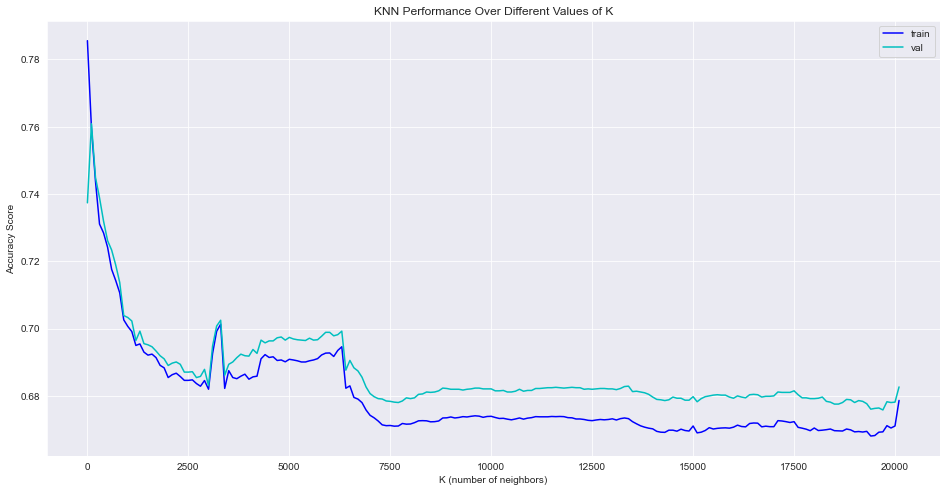

The highest train accuracy occured with a number of neighbors equal to: 101


In [68]:
plt.figure(figsize=(16,8))
plt.plot(K_values, train_accuracies, label="train", color = 'b')
plt.plot(K_values, test_accuracies, label="val", color = 'c')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Accuracy Score")
plt.title("KNN Performance Over Different Values of K")
plt.legend()
plt.show()
print(f"The highest train accuracy occured with a number of neighbors equal to: {K_values[test_accuracies.index(max(test_accuracies))]}")

In [69]:
train_accuracies2 = []
test_accuracies2 = []
K_values2 = []

if (os.path.exists('preRunModels/trainAccuracies2.joblib') & os.path.exists('preRunModels/testAccuracies2.joblib') & os.path.exists('preRunModels/kValues2.joblib')):
    train_accuracies2 = joblib.load('preRunModels/trainAccuracies2.joblib')
    test_accuracies2 = joblib.load('preRunModels/testAccuracies2.joblib')
    K_values2 = joblib.load('preRunModels/kValues2.joblib')
    print("Pre-run model will be loaded")
else:
    for k in range(1, 101):

            knnXrfe = KNeighborsClassifier(n_neighbors=k).fit(x1_train, y1_train)

            y_train_pred = knnXrfe.predict(x1_train)
            y_test_pred = knnXrfe.predict(x1_val)

            train_accuracies2.append(accuracy_score(y1_train, y_train_pred))
            test_accuracies2.append(accuracy_score(y1_val, y_test_pred))
            K_values2.append(k)

            print(f"K={k}/100", end="\r")
            
    joblib.dump(train_accuracies2, 'preRunModels/trainAccuracies2.joblib')
    joblib.dump(test_accuracies2, 'preRunModels/testAccuracies2.joblib')
    joblib.dump(K_values2, 'preRunModels/kValues2.joblib')

Pre-run model will be loaded


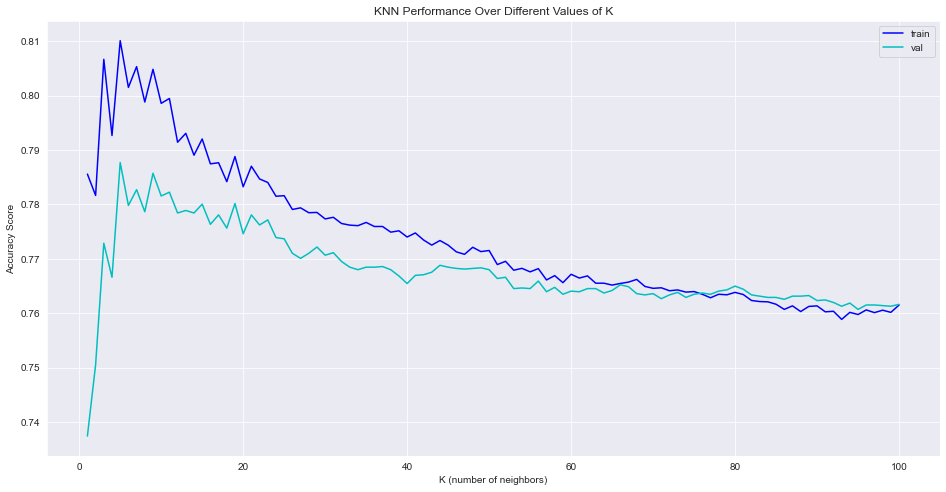

The highest train accuracy occured with a number of neighbors equal to: 5


In [70]:
plt.figure(figsize=(16,8))
plt.plot(K_values2, train_accuracies2, label="train", color = 'b')
plt.plot(K_values2, test_accuracies2, label="val", color = 'c')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Accuracy Score")
plt.title("KNN Performance Over Different Values of K")
plt.legend()
plt.show()
print(f"The highest train accuracy occured with a number of neighbors equal to: {K_values2[test_accuracies2.index(max(test_accuracies2))]}")

In [71]:
start = time.time()
timeResultsData = []

knnXrfe = KNeighborsClassifier(n_neighbors = 5).fit(x1_train, y1_train)

y1_train_pred3 = knnXrfe.predict(x1_train)
y1_val_pred3 = knnXrfe.predict(x1_val)

trainScore3 = accuracy_score(y1_train, y1_train_pred3)
valScore3 = accuracy_score(y1_val, y1_val_pred3)
precScore3 = precision_score(y1_val, y1_val_pred3)
recScore3 = recall_score(y1_val, y1_val_pred3)

end = time.time()
timeResultsData.append('KNN')
timeResultsData.append(trainScore3)
timeResultsData.append(valScore3)
timeResultsData.append(precScore3)
timeResultsData.append(recScore3)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore3}")
print(f"Accuracy score of the valuation set: {valScore3}")
print(f"Precision score of the valuation set: {precScore3}")
print(f"Recall score of the valuation set: {recScore3}")

Time: 13.31 seconds
Accuracy score of the train set: 0.8226295137336711
Accuracy score of the valuation set: 0.7671804380577124
Precision score of the valuation set: 0.7594850948509485
Recall score of the valuation set: 0.7808219178082192


In [72]:
depths = np.arange(1, 51)
depth_value = []
train_accuracies = []
test_accuracies = []

for depth in depths:
    dtXrfe = DecisionTreeClassifier(max_depth = depth, random_state=12)
    dtXrfe.fit(x1_train, y1_train)
    
    y_train_pred = dtXrfe.predict(x1_train)
    y_test_pred = dtXrfe.predict(x1_val)

    train_accuracies.append(accuracy_score(y1_train, y_train_pred))
    test_accuracies.append(accuracy_score(y1_val, y_test_pred))
    depth_value.append(depth)

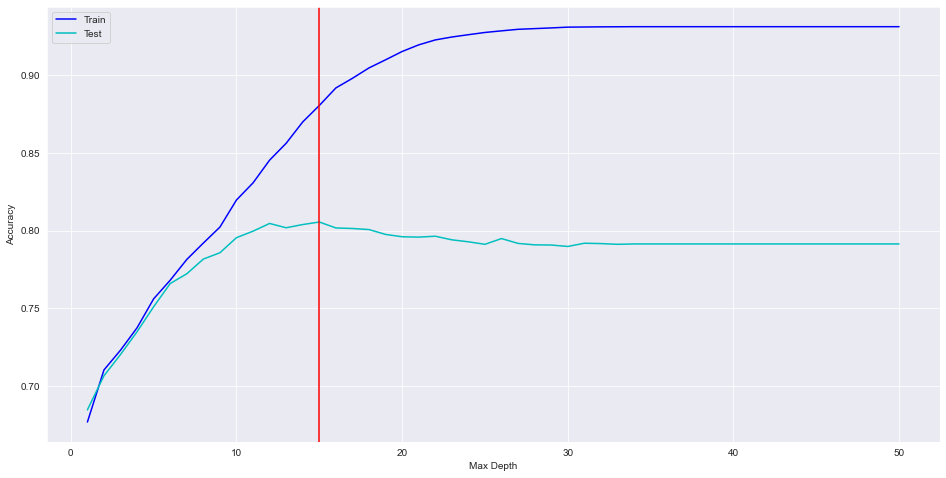

In [73]:
plt.figure(figsize = (16,8))
plt.plot(depth_value, train_accuracies, label="Train", color = 'b')
plt.plot(depth_value, test_accuracies, label="Test", color = 'c')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()

plt.axvline(x=15, color = 'red')
plt.show()

In [74]:
minSamples = np.arange(1, 20000)
min_value = []
train_accuracies3 = []
test_accuracies3 = []

if (os.path.exists('preRunModels/trainAccuracies3.joblib') & os.path.exists('preRunModels/testAccuracies3.joblib') & os.path.exists('preRunModels/minLeafValues.joblib')):
    train_accuracies3 = joblib.load('preRunModels/trainAccuracies3.joblib')
    test_accuracies3 = joblib.load('preRunModels/testAccuracies3.joblib')
    min_value = joblib.load('preRunModels/minLeafValues.joblib')
    print("Pre-run model will be loaded")
else:
    for minS in minSamples:
        dtXrfe = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = minS, random_state=12)
        dtXrfe.fit(x1_train, y1_train)

        y_train_pred = dtXrfe.predict(x1_train)
        y_test_pred = dtXrfe.predict(x1_val)

        train_accuracies3.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies3.append(accuracy_score(y1_val, y_test_pred))
        min_value.append(minS)

        print(f"min samples={minS}/20000", end="\r")
        
    joblib.dump(train_accuracies3, 'preRunModels/trainAccuracies3.joblib')
    joblib.dump(test_accuracies3, 'preRunModels/testAccuracies3.joblib')
    joblib.dump(min_value, 'preRunModels/minLeafValues.joblib')

Pre-run model will be loaded


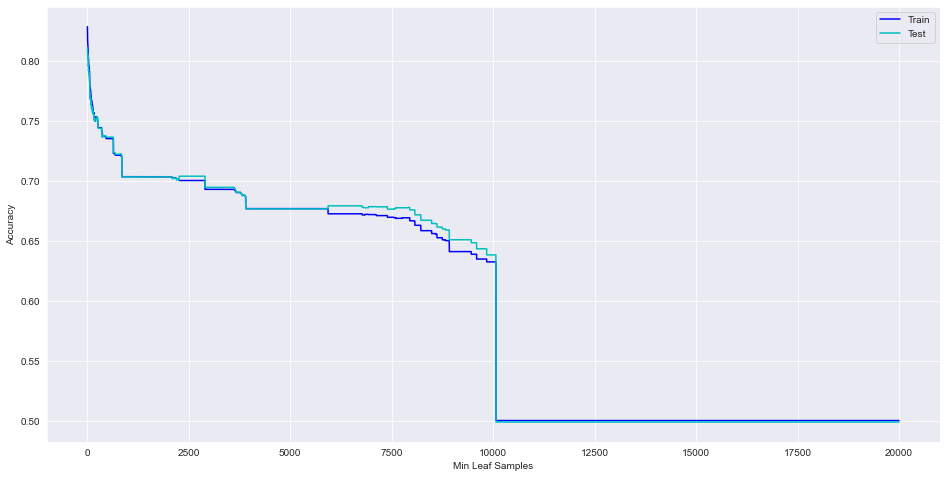

In [75]:
plt.figure(figsize = (16,8))
plt.plot(min_value, train_accuracies3, label="Train", color = 'b')
plt.plot(min_value, test_accuracies3, label="Test", color = 'c')
plt.xlabel("Min Leaf Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [76]:
start = time.time()
timeResultsData = []

dtXrfe = DecisionTreeClassifier(max_depth = 15, random_state=12)
dtXrfe.fit(x1_train, y1_train)

y1_train_pred4 = dtXrfe.predict(x1_train)
y1_val_pred4 = dtXrfe.predict(x1_val)

trainScore4 = accuracy_score(y1_train, y1_train_pred4)
valScore4 = accuracy_score(y1_val, y1_val_pred4)
precScore4 = precision_score(y1_val, y1_val_pred4)
recScore4 = recall_score(y1_val, y1_val_pred4)

end = time.time()
timeResultsData.append('Tree')
timeResultsData.append(trainScore4)
timeResultsData.append(valScore4)
timeResultsData.append(precScore4)
timeResultsData.append(recScore4)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore4}")
print(f"Accuracy score of the valuation set: {valScore4}")
print(f"Precision score of the valuation set: {precScore4}")
print(f"Recall score of the valuation set: {recScore4}")

Time: 0.08 seconds
Accuracy score of the train set: 0.8806437192668752
Accuracy score of the valuation set: 0.805539459960598
Precision score of the valuation set: 0.7934806876534941
Recall score of the valuation set: 0.8251683306245646


In [77]:
nEst = np.arange(1, 101)
estimator_value = []
train_accuracies4 = []
test_accuracies4 = []

if (os.path.exists('preRunModels/trainAccuracies4.joblib') & os.path.exists('preRunModels/testAccuracies4.joblib') & os.path.exists('preRunModels/nEstimatorValues.joblib')):
    train_accuracies4 = joblib.load('preRunModels/trainAccuracies4.joblib')
    test_accuracies4 = joblib.load('preRunModels/testAccuracies4.joblib')
    estimator_value = joblib.load('preRunModels/nEstimatorValues.joblib')
    print("Pre-run model will be loaded")
else:
    for est in nEst:
        rfXrfe = RandomForestClassifier(n_estimators = est)
        rfXrfe.fit(x1_train, y1_train)

        y_train_pred = rfXrfe.predict(x1_train)
        y_test_pred = rfXrfe.predict(x1_val)

        train_accuracies4.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies4.append(accuracy_score(y1_val, y_test_pred))
        estimator_value.append(est)

        print(f"nEst={est}/100", end="\r")
        
    joblib.dump(train_accuracies4, 'preRunModels/trainAccuracies4.joblib')
    joblib.dump(test_accuracies4, 'preRunModels/testAccuracies4.joblib')
    joblib.dump(estimator_value, 'preRunModels/nEstimatorValues.joblib')

Pre-run model will be loaded


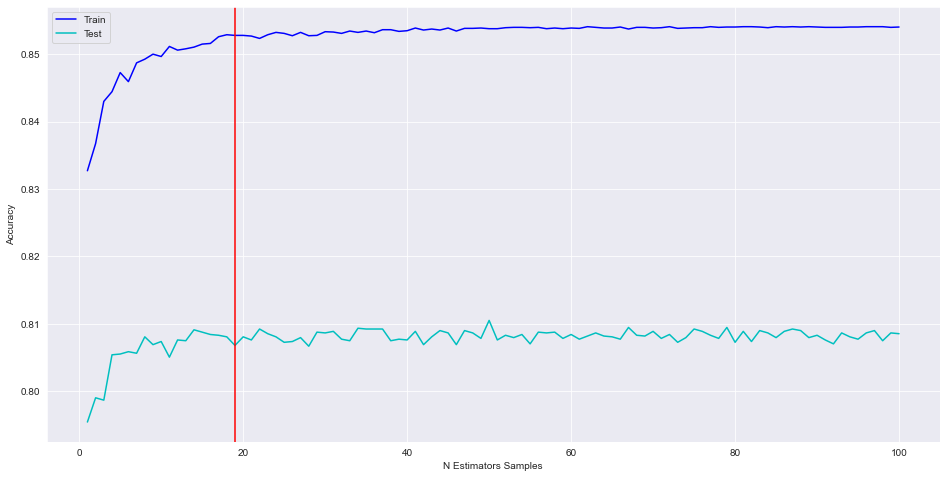

In [78]:
plt.figure(figsize = (16,8))
plt.plot(estimator_value, train_accuracies4, label="Train", color = 'b')
plt.plot(estimator_value, test_accuracies4, label="Test", color = 'c')
plt.xlabel("N Estimators Samples")
plt.ylabel("Accuracy")
plt.legend()

plt.axvline(x=19, color = 'red')
plt.show()

In [79]:
cv_scores = []
nEst = []

if (os.path.exists('preRunModels/cv_scores.joblib') & os.path.exists('preRunModels/nEst.joblib')):
    cv_scores = joblib.load('preRunModels/cv_scores.joblib')
    nEst = joblib.load('preRunModels/nEst.joblib')
    print("Pre-run model will be loaded")
else:
    for n in range(1,100):
        rfXfre = RandomForestClassifier(n_estimators = n)
        cv_score = np.mean(cross_val_score(rfXfre, x1_train, y1_train, cv=5))
        cv_scores.append(cv_score)
        nEst.append(n)
        
    joblib.dump(cv_scores, 'preRunModels/cv_scores.joblib')
    joblib.dump(nEst, 'preRunModels/nEst.joblib')

Pre-run model will be loaded


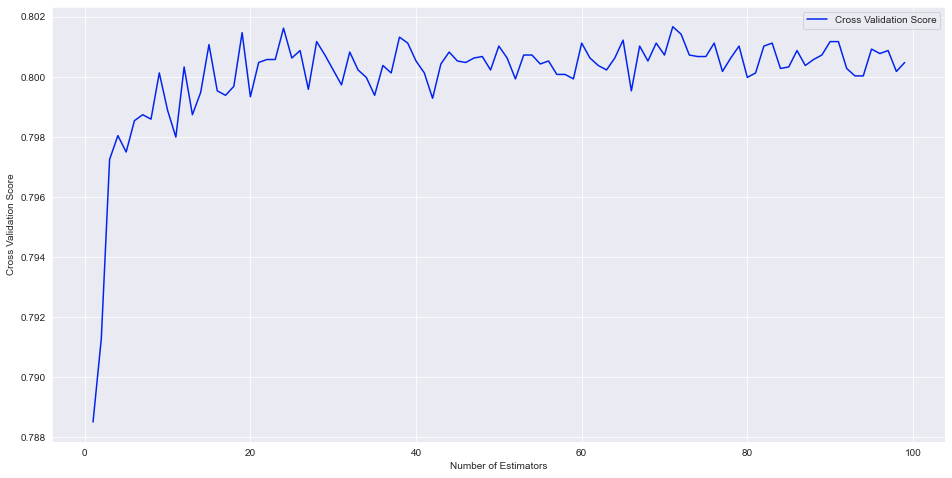

The highest train cross val score occured with a number of neighbors equal to: 71


In [80]:
plt.figure(figsize = (16,8))
plt.plot(nEst, cv_scores, label="Cross Validation Score")
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.show()
bestNest = nEst[cv_scores.index(max(cv_scores))]
print(f"The highest train cross val score occured with a number of neighbors equal to: {bestNest}")

In [81]:
depth2 = np.arange(1, 51)
depth2_value = []
train_accuracies5 = []
test_accuracies5 = []

if (os.path.exists('preRunModels/trainAccuracies5.joblib') & os.path.exists('preRunModels/testAccuracies5.joblib') & os.path.exists('preRunModels/depth2Values.joblib')):
    train_accuracies5 = joblib.load('preRunModels/trainAccuracies5.joblib')
    test_accuracies5 = joblib.load('preRunModels/testAccuracies5.joblib')
    depth2_value = joblib.load('preRunModels/depth2Values.joblib')
    print("Pre-run model will be loaded")
else:
    for depth in depth2:
        rfXrfe = RandomForestClassifier(max_depth = depth)
        rfXrfe.fit(x1_train, y1_train)

        y_train_pred = rfXrfe.predict(x1_train)
        y_test_pred = rfXrfe.predict(x1_val)

        train_accuracies5.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies5.append(accuracy_score(y1_val, y_test_pred))
        depth2_value.append(depth)

        print(f"depth={depth}/50", end="\r")
        
    joblib.dump(train_accuracies5, 'preRunModels/trainAccuracies5.joblib')
    joblib.dump(test_accuracies5, 'preRunModels/testAccuracies5.joblib')
    joblib.dump(depth2_value, 'preRunModels/depth2Values.joblib')

Pre-run model will be loaded


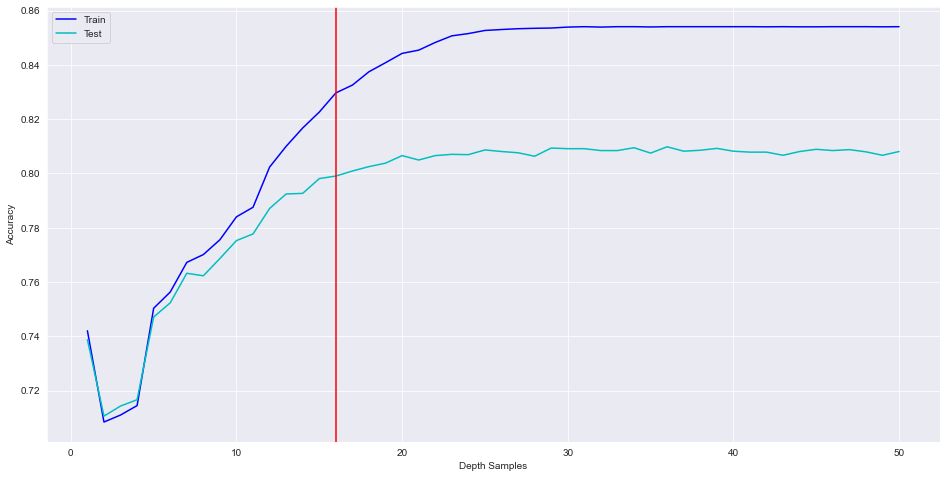

In [82]:
plt.figure(figsize = (16,8))
plt.plot(depth2_value, train_accuracies5, label="Train", color = 'b')
plt.plot(depth2_value, test_accuracies5, label="Test", color = 'c')
plt.xlabel("Depth Samples")
plt.ylabel("Accuracy")
plt.legend()

plt.axvline(x=16, color = 'red')
plt.show()

In [83]:
cv_scores2 = []
depth3 = []

if (os.path.exists('preRunModels/cv_scores2.joblib') & os.path.exists('preRunModels/depth3.joblib')):
    cv_scores2 = joblib.load('preRunModels/cv_scores2.joblib')
    depth3 = joblib.load('preRunModels/depth3.joblib')
    print("Pre-run model will be loaded")
else:
    for d in range(1,100):
        rfXfre = RandomForestClassifier(max_depth = d)
        cv_score = np.mean(cross_val_score(rfXfre, x1_train, y1_train, cv=5))
        cv_scores2.append(cv_score)
        depth3.append(d)
        
    joblib.dump(cv_scores2, 'preRunModels/cv_scores2.joblib')
    joblib.dump(depth3, 'preRunModels/depth3.joblib')

Pre-run model will be loaded


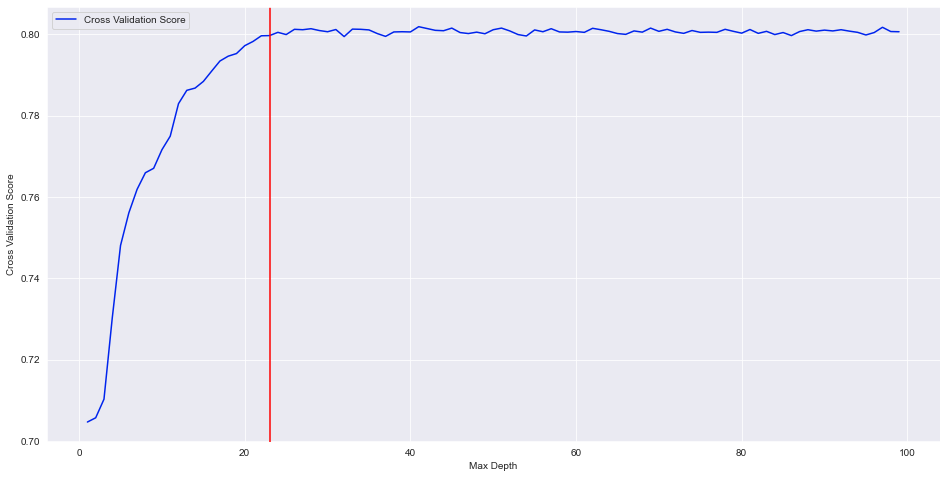

In [84]:
plt.figure(figsize = (16,8))
plt.plot(depth3, cv_scores2, label="Cross Validation Score")
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.axvline(x = 23, color = 'red')
plt.show()

In [85]:
start = time.time()
timeResultsData = []

rfXrfe = RandomForestClassifier(n_estimators = bestNest, max_depth = 23, random_state=12)
rfXrfe.fit(x1_train, y1_train)

y1_train_pred5 = rfXrfe.predict(x1_train)
y1_val_pred5 = rfXrfe.predict(x1_val)

trainScore5 = accuracy_score(y1_train, y1_train_pred5)
valScore5 = accuracy_score(y1_val, y1_val_pred5)
precScore5 = precision_score(y1_val, y1_val_pred5)
recScore5 = recall_score(y1_val, y1_val_pred5)

end = time.time()
timeResultsData.append('Forrest')
timeResultsData.append(trainScore5)
timeResultsData.append(valScore5)
timeResultsData.append(precScore5)
timeResultsData.append(recScore5)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore5}")
print(f"Accuracy score of the valuation set: {valScore5}")
print(f"Precision score of the valuation set: {precScore5}")
print(f"Recall score of the valuation set: {recScore5}")

Time: 1.33 seconds
Accuracy score of the train set: 0.921124521929171
Accuracy score of the valuation set: 0.7856066751651408
Precision score of the valuation set: 0.7758814282506176
Recall score of the valuation set: 0.8021824936150452


In [86]:
estimatorBag = [
    ('LogisticRegression', logXrfe),
    ('SVC', svcXrfe),
    ('KNN', knnXrfe)
]

In [87]:
start = time.time()
timeResultsData = []

bagXrfe = VotingClassifier(estimators=estimatorBag, voting="soft", weights=[1,1,2])
bagXrfe.fit(x1_train, y1_train)

y1_train_pred6 = bagXrfe.predict(x1_train)
y1_val_pred6 = bagXrfe.predict(x1_val)

trainScore6 = accuracy_score(y1_train, y1_train_pred6)
valScore6 = accuracy_score(y1_val, y1_val_pred6)
precScore6 = precision_score(y1_val, y1_val_pred6)
recScore6 = recall_score(y1_val, y1_val_pred6)

end = time.time()
timeResultsData.append('Bag')
timeResultsData.append(trainScore6)
timeResultsData.append(valScore6)
timeResultsData.append(precScore6)
timeResultsData.append(recScore6)
totalTime = round(end - start,2)
timeResultsData.append(totalTime)
timedResultList.append(timeResultsData)

print(f"Time: {totalTime} seconds")
print(f"Accuracy score of the train set: {trainScore6}")
print(f"Accuracy score of the valuation set: {valScore6}")
print(f"Precision score of the valuation set: {precScore6}")
print(f"Recall score of the valuation set: {recScore6}")

Time: 143.06 seconds
Accuracy score of the train set: 0.8211890925346446
Accuracy score of the valuation set: 0.7829412446401669
Precision score of the valuation set: 0.7728699551569507
Recall score of the valuation set: 0.8003250522405386


In [88]:
timeDF = pd.DataFrame(timedResultList)
timeDF.columns = ['Model Type', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'Time (s)']
timeDF

,Model Type,Train Accuracy,Test Accuracy,Precision,Recall,Time (s)
0,Log Reg,0.774450,0.775988,0.770881,0.784305,0.94
1,SVC,0.807182,0.773438,0.760177,0.797771,129.68
2,KNN,0.822630,0.767180,0.759485,0.780822,13.31
3,Tree,0.880644,0.805539,0.793481,0.825168,0.08
4,Forrest,0.921125,0.785607,0.775881,0.802182,1.33
5,Bag,0.821189,0.782941,0.772870,0.800325,143.06


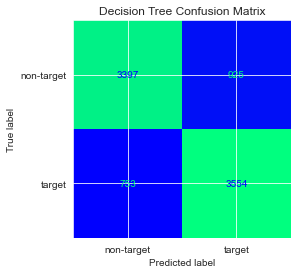

In [89]:
labels = ['non-target', 'target']
confMatrix = plot_confusion_matrix(dtXrfe, x1_val ,y1_val, cmap = 'winter', colorbar = False, display_labels= labels)
plt.title('Decision Tree Confusion Matrix')
plt.show(confMatrix)

In [90]:
testTargets = dtXrfe.predict(predXrfe)
predXrfe.insert(2, 'Target', testTargets)
predXrfe

,city_development_index,gender_Non-Male ID,Target,relevent_experience_No relevent experience,enrolled_university_No Enrollment,enrolled_university_Other,enrolled_university_Part time course,education_level_High School,education_level_Masters,education_level_Other,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_Other,last_new_job_never
0,0.827,0,1.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.920,1,0.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.624,0,0.0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.827,0,0.0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.920,0,0.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,0,0.0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2125,0.897,0,0.0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
2126,0.887,0,0.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2127,0.804,0,0.0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
